In [1]:
import os
import torch
import tifffile as tiff
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np

class ImageMaskDataset(Dataset):
    def __init__(self, image_dir, mask_dir, resize=(768, 768)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.resize = resize

        # List of image files
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.tif')])

        # Match masks by replacing 'image_v2_' with 'image_v2_mask_'
        mask_dir_files = os.listdir(mask_dir)
        self.mask_files = []
        for img_name in self.image_files:
            mask_name = img_name.replace('image_v2_', 'image_v2_mask_')
            if mask_name not in mask_dir_files:
                raise FileNotFoundError(f"Mask {mask_name} not found for image {img_name}")
            self.mask_files.append(mask_name)

        assert len(self.image_files) == len(self.mask_files), "Image and mask count mismatch!"

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])

        # Load TIFF images
        image = tiff.imread(img_path)
        mask = tiff.imread(mask_path)
        
        # If 3D stack, take middle slice
        if image.ndim == 3:
            image = image[image.shape[0] // 2]

        # Contrast stretch image to 0-1
        image = (image - image.min()) / (image.max() - image.min() + 1e-8)*255
        image = torch.from_numpy(image).float()

        # Convert mask to tensor
        mask = (mask - mask.min()) / (mask.max() - mask.min() + 1e-8)*255
        #mask = ((mask < 4) | (mask == 118.005585) | (mask == 116.12109375) ).astype(np.float32)
        mask = torch.from_numpy(mask).float()

        # Add channel dimension to image if grayscale
        if image.ndim == 2:
            image = image.unsqueeze(0)  # C x H x W
        else:
            image = image.permute(2,0,1)  # HWC -> CHW

        # Resize image and mask
        image = F.interpolate(image.unsqueeze(0), size=self.resize, mode='bilinear', align_corners=False).squeeze(0)
        mask = F.interpolate(mask.unsqueeze(0).unsqueeze(0).float(), size=self.resize, mode='nearest').squeeze(0).float()

        return image, mask

# ---------------- Example Usage ----------------
if __name__ == "__main__":
    image_dir = "Data/Images"
    mask_dir = "Data/Masks"

    dataset = ImageMaskDataset(image_dir, mask_dir, resize=(512, 512))
    dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0)

    # Test batch
    images, masks = next(iter(dataloader))
    print("Image batch shape:", images.shape)
    print("Mask batch shape:", masks.shape)



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/asmustangdalsgaard/miniforge3/envs/dtu02452/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/asmustangdalsgaard/miniforge3/envs/dtu02452/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/asmustangdalsgaard/miniforge3/envs/dtu02452/lib/python3.11/site-packages/ipyk

ModuleNotFoundError: No module named 'tifffile'

In [38]:
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split dataset
train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size]
)

train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=2, shuffle=False)

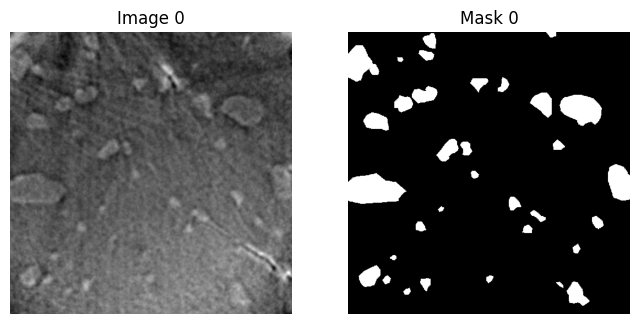

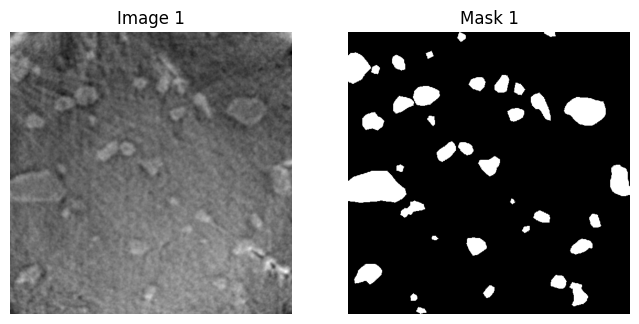

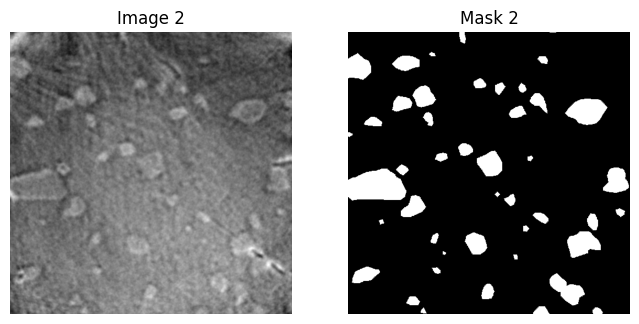

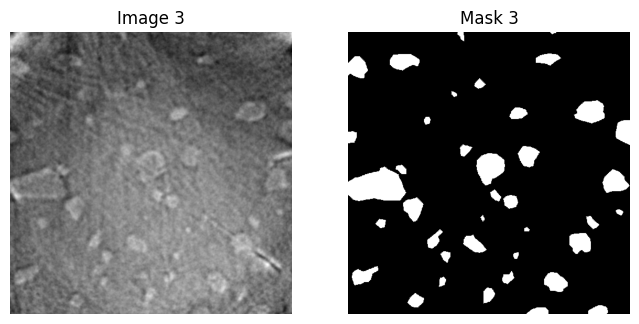

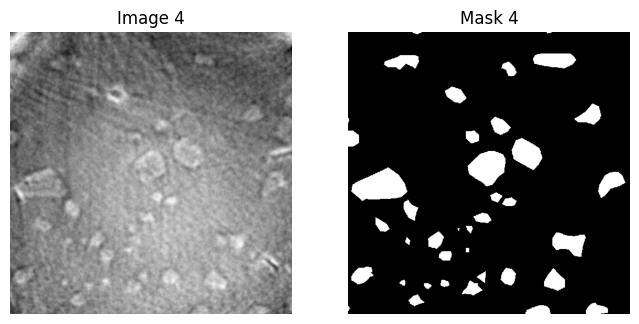

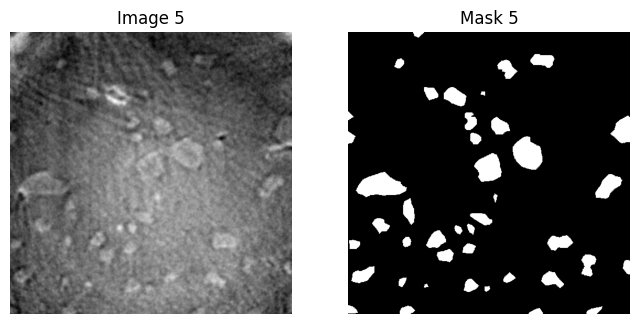

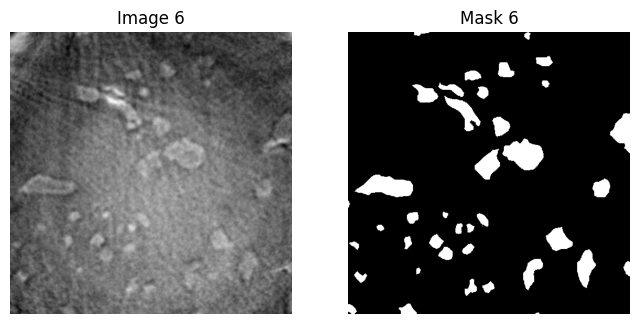

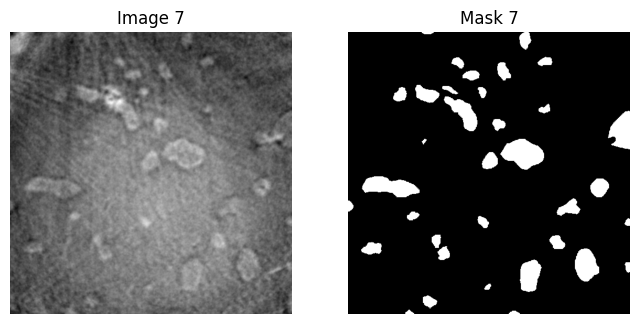

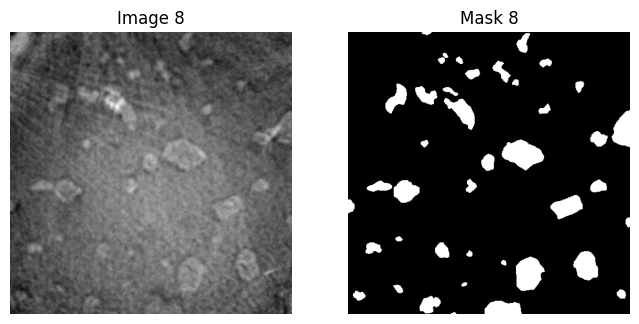

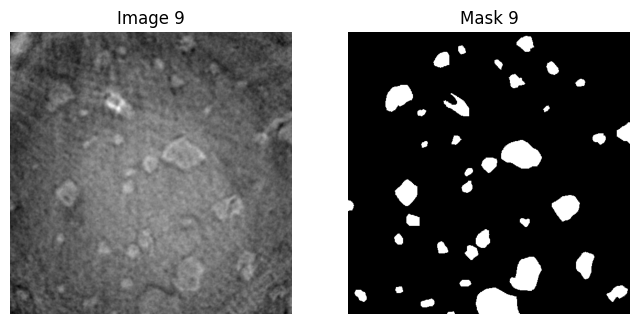

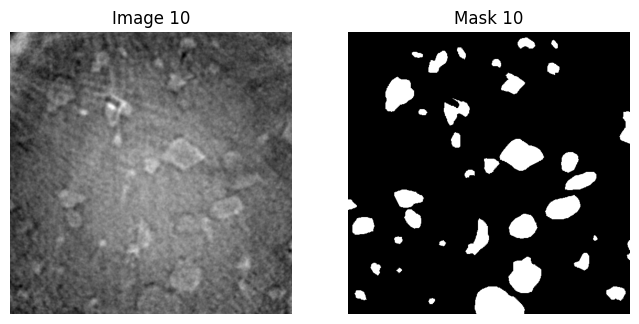

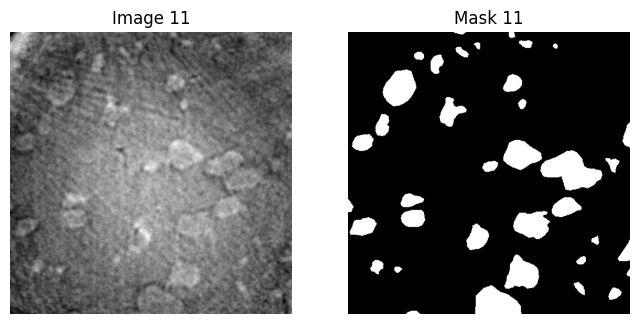

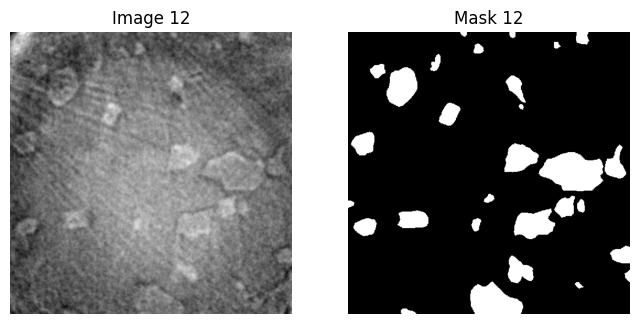

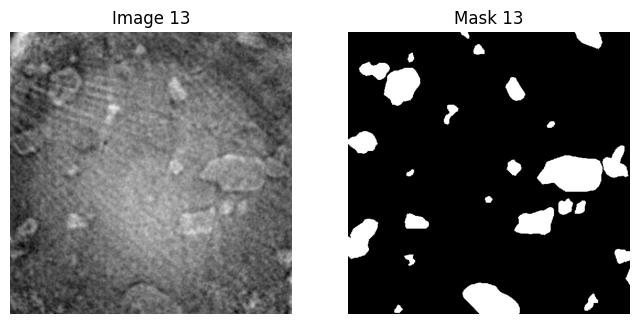

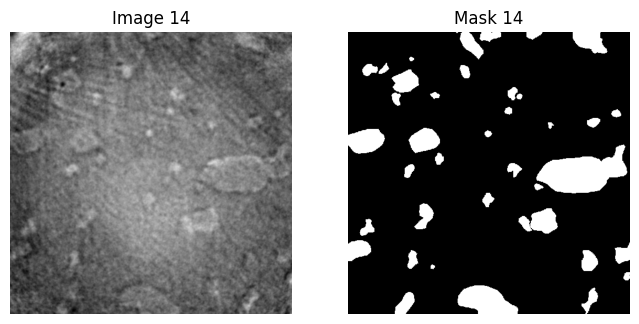

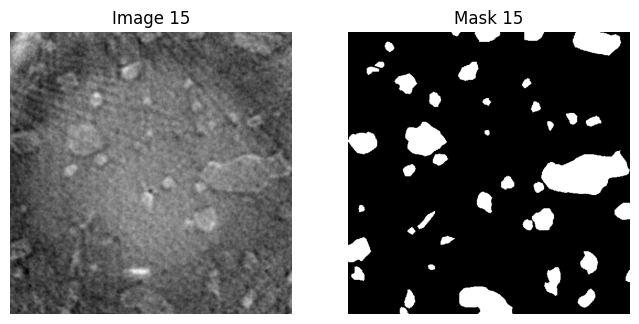

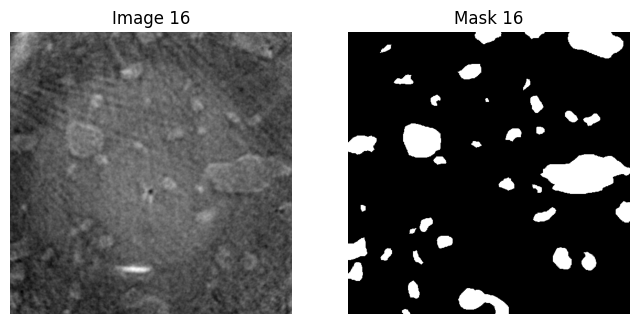

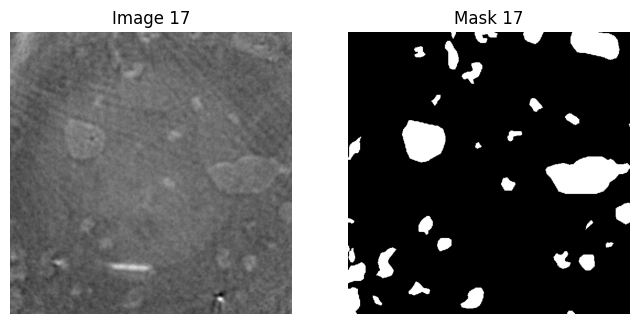

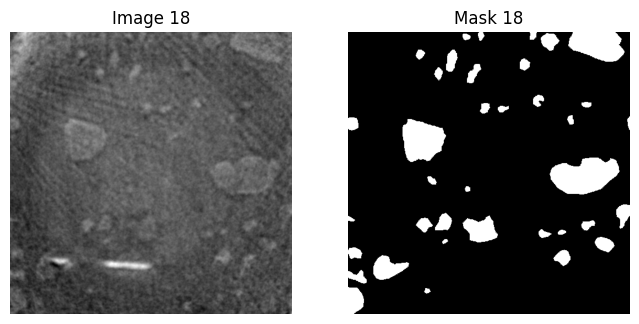

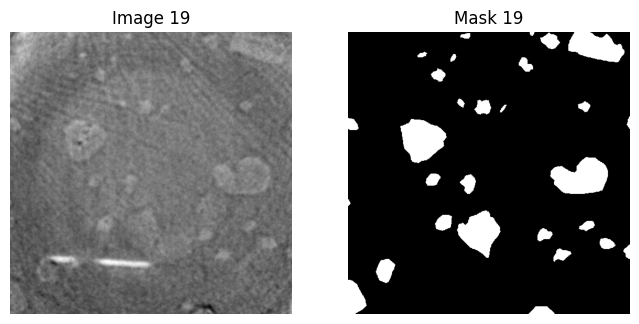

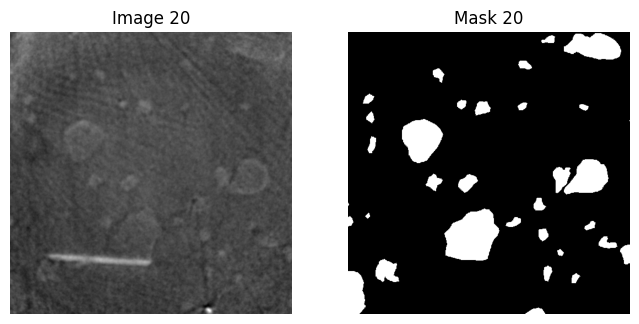

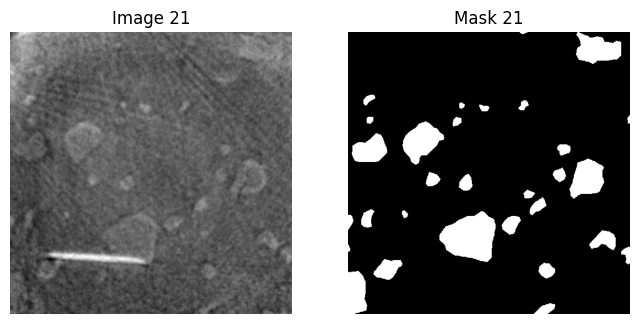

In [39]:
import matplotlib.pyplot as plt

for idx in range(len(dataset)):
    # Get image and mask
    img, mask = dataset[idx]  # assuming dataset returns (image, mask)
    
    # Convert tensors to numpy
    img_np = img.permute(1,2,0).numpy() if img.ndim == 3 else img.numpy()
    mask_np = mask.squeeze().numpy()  # 1xHxW -> HxW
    
    # Normalize mask for visualization
    mask_vis = (mask_np - mask_np.min()) / (mask_np.max() - mask_np.min() + 1e-8)
    
    # Plot
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(img_np, cmap='gray')
    plt.title(f"Image {idx}")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(mask_vis, cmap='gray')
    plt.title(f"Mask {idx}")
    plt.axis("off")

    plt.show()


In [27]:
from collections import Counter

pixel_counter = Counter()

for i in range(len(dataset)):
    _, mask = dataset[i]
    mask_np = mask.numpy().squeeze()

    # Flatten and filter pixels > 50
    pixels_gt_50 = mask_np[mask_np > 50].flatten().tolist()

    # Update counter
    pixel_counter.update(pixels_gt_50)

# Get most common values
most_common = pixel_counter.most_common(3)

print("Most frequent pixel values > 50:")
for val, cnt in most_common:
    print(f"value={val} → count={cnt}")


Most frequent pixel values > 50:
value=118.00558471679688 → count=12933
value=116.12109375 → count=5384
value=254.99493408203125 → count=2445


In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

def double_conv(in_channels, out_channels):
    
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

class unet(nn.Module):
    def __init__(self, in_channels=1, num_classes=1):
        super(unet, self).__init__()

        self.conv_down1 = double_conv(in_channels, 16)
        self.conv_down2 = double_conv(16, 32)
        self.conv_down3 = double_conv(32, 64)
        self.conv_down4 = double_conv(64, 128)
        self.conv_down5 = double_conv(128, 256)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.conv_up4 = double_conv(128 + 256, 128)
        self.conv_up3 = double_conv(64 + 128, 64)
        self.conv_up2 = double_conv(32 + 64, 32)
        self.conv_up1 = double_conv(32 + 16, 16)
        
        self.last_conv = nn.Conv2d(16, num_classes, kernel_size=1)
    
    def forward(self, x):
        conv1 = self.conv_down1(x)  
        x = self.maxpool(conv1)     
        conv2 = self.conv_down2(x)  
        x = self.maxpool(conv2)     
        conv3 = self.conv_down3(x) 
        x = self.maxpool(conv3)
        conv4 = self.conv_down4(x)  
        x = self.maxpool(conv4)   
        x = self.conv_down5(x)      
        x = self.upsample(x)        
    

        x = torch.cat([x, conv4], dim=1) 
        x = self.conv_up4(x) 
        x = self.upsample(x) 
        x = torch.cat([x, conv3], dim=1) 
        x = self.conv_up3(x) 
        x = self.upsample(x)   
        x = torch.cat([x, conv2], dim=1) 
        x = self.conv_up2(x) 
        x = self.upsample(x)      
        x = torch.cat([x, conv1], dim=1) 
        
        x = self.conv_up1(x)
        
        out = self.last_conv(x)
        
        return out


In [41]:
def train(model, train_loader, val_loader, optimizer, criterion, device, num_epochs):
    history = {k: [] for k in ["train_loss","val_loss","val_dice","val_iou","val_acc","val_sens","val_spec"]}
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        num_batches = len(train_loader)
        for batch_idx, (images, masks) in enumerate(train_loader):
            images = images.to(device)
            masks = masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            
            loss = criterion(outputs, masks)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            train_loss += loss.item()
        
        model.eval()
        val_loss = 0.0
        dice_scores, iou_scores, acc_scores, sens_scores, spec_scores = [], [], [], [], []
        eps = 1e-7
        num_val_batches = len(val_loader)
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)
            
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()

                probs = torch.sigmoid(outputs)
                preds = (probs >= 0.5).float()
                targets = masks.float()

                intersection = (preds * targets).sum(dim=(1,2,3))
                pred_sum = preds.sum(dim=(1,2,3))
                mask_sum = targets.sum(dim=(1,2,3))
                union = ((preds + targets) > 0).float().sum(dim=(1,2,3))

                dice = (2*intersection + eps) / (pred_sum + mask_sum + eps)
                iou  = (intersection + eps) / (union + eps)

                tp = intersection
                tn = ((1 - preds) * (1 - targets)).sum(dim=(1,2,3))
                fp = (preds * (1 - targets)).sum(dim=(1,2,3))
                fn = ((1 - preds) * targets).sum(dim=(1,2,3))

                acc  = (tp + tn + eps) / (tp + tn + fp + fn + eps)
                sens = (tp + eps) / (tp + fn + eps)
                spec = (tn + eps) / (tn + fp + eps)

                dice_scores.append(dice.mean().item())
                iou_scores.append(iou.mean().item())
                acc_scores.append(acc.mean().item())
                sens_scores.append(sens.mean().item())
                spec_scores.append(spec.mean().item())
        
        avg_train_loss = train_loss / num_batches
        avg_val_loss = val_loss / num_val_batches
        val_dice = float(np.mean(dice_scores))
        val_iou = float(np.mean(iou_scores))
        val_acc = float(np.mean(acc_scores))
        val_sens = float(np.mean(sens_scores))
        val_spec = float(np.mean(spec_scores))

        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)
        history["val_dice"].append(val_dice)
        history["val_iou"].append(val_iou)
        history["val_acc"].append(val_acc)
        history["val_sens"].append(val_sens)
        history["val_spec"].append(val_spec)

        print(f"Epoch {epoch:03d}/{num_epochs} | "
              f"train_loss={avg_train_loss:.4f} | val_loss={avg_val_loss:.4f} | "
              f"Dice={val_dice:.4f} | IoU={val_iou:.4f} | "
              f"Acc={val_acc:.4f} | Sens={val_sens:.4f} | Spec={val_spec:.4f}")
    return history
        

In [42]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = unet().to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
num_epochs = 50

history = train(model, train_loader, val_loader, optimizer, criterion, device, num_epochs)


Epoch 000/50 | train_loss=0.7360 | val_loss=0.7226 | Dice=0.2233 | IoU=0.1257 | Acc=0.1268 | Sens=0.9955 | Spec=0.0014
Epoch 001/50 | train_loss=0.7021 | val_loss=0.7211 | Dice=0.2233 | IoU=0.1257 | Acc=0.1269 | Sens=0.9954 | Spec=0.0015
Epoch 002/50 | train_loss=0.6810 | val_loss=0.7214 | Dice=0.2231 | IoU=0.1256 | Acc=0.1270 | Sens=0.9940 | Spec=0.0019
Epoch 003/50 | train_loss=0.6640 | val_loss=0.7188 | Dice=0.2218 | IoU=0.1248 | Acc=0.1284 | Sens=0.9858 | Spec=0.0047
Epoch 004/50 | train_loss=0.6509 | val_loss=0.7093 | Dice=0.2229 | IoU=0.1255 | Acc=0.2099 | Sens=0.9009 | Spec=0.1103
Epoch 005/50 | train_loss=0.6407 | val_loss=0.6933 | Dice=0.2612 | IoU=0.1503 | Acc=0.4745 | Sens=0.7326 | Spec=0.4367
Epoch 006/50 | train_loss=0.6300 | val_loss=0.6739 | Dice=0.2949 | IoU=0.1730 | Acc=0.6641 | Sens=0.5557 | Spec=0.6791
Epoch 007/50 | train_loss=0.6193 | val_loss=0.6556 | Dice=0.3901 | IoU=0.2425 | Acc=0.7952 | Sens=0.5204 | Spec=0.8346
Epoch 008/50 | train_loss=0.6104 | val_loss=0.64

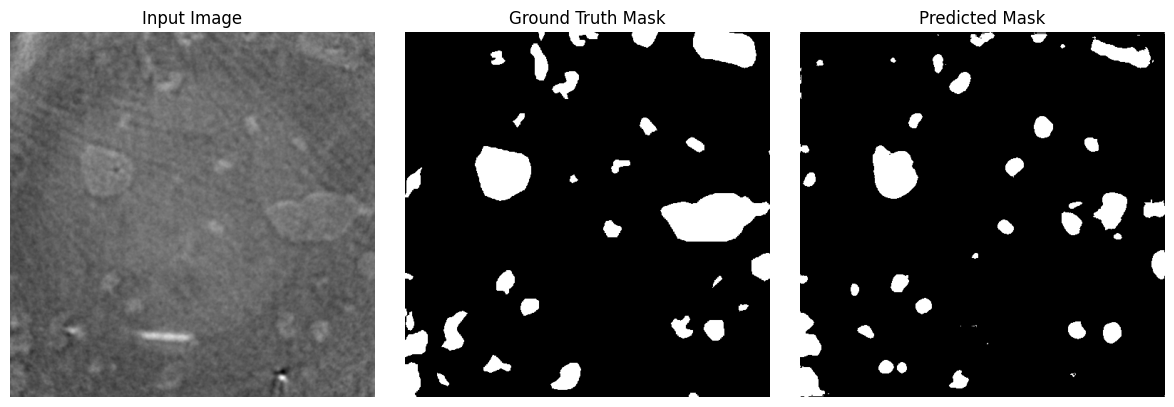

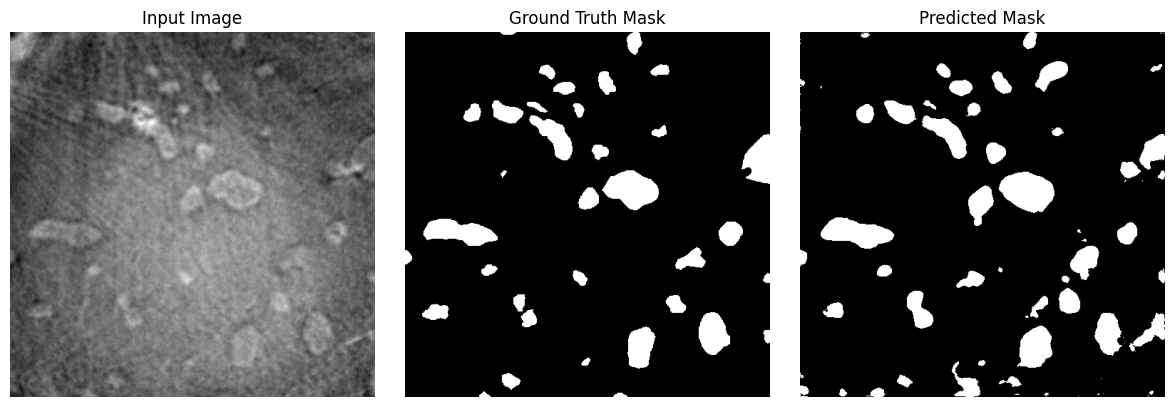

In [43]:
import matplotlib.pyplot as plt
model.eval()  # make sure the model is in eval mode

# Take one batch from the test loader
images, masks = next(iter(test_loader))  # images: [B,C,H,W], masks: [B,1,H,W]

for i in range(images.size(0)):
    image = images[i].to(device).unsqueeze(0)  # add batch dim
    mask = masks[i].to(device)

    with torch.no_grad():
        output = model(image)                  # [1,1,H,W]
        probs = torch.sigmoid(output)          # probabilities
        pred_mask = (probs > 0.5).float()     # binary mask

    # Move to CPU for plotting
    image_cpu = image.squeeze(0).cpu()
    mask_cpu = mask.cpu()
    pred_cpu = pred_mask.squeeze(0).cpu()

    # Plot
    fig, axs = plt.subplots(1,3, figsize=(12,4))
    axs[0].imshow(image_cpu.squeeze(0), cmap='gray')
    axs[0].set_title("Input Image")
    axs[0].axis('off')

    axs[1].imshow(mask_cpu.squeeze(0), cmap='gray')
    axs[1].set_title("Ground Truth Mask")
    axs[1].axis('off')

    axs[2].imshow(pred_cpu.squeeze(0), cmap='gray')
    axs[2].set_title("Predicted Mask")
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()

    # glans